In [1]:
import pickle
import matplotlib.pyplot as plt
import backtest_tools.portfolio_tools as pt

In [2]:
# Import Strategy Class
from spy_gld_momentum_strategy_class import spy_gld_momentum_strategy

In [3]:
# Utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

# Relevant Libraries
import yfinance as yf
from scipy.optimize import minimize
from scipy.optimize import Bounds
from backtest_tools import portfolio_tools as pt

class spy_gld_momentum_strategy():

    def __init__(self):

        self.index_tickers = ['HL', '^GSPC']
        self.etf_tickers = ['SPY', 'GLD']
     
        # Get investment unverse's daily returns
        self.index_close_returns, self.index_open_returns = self.get_returns(self.index_tickers)
        self.etf_close_returns, self.etf_open_returns = self.get_returns(self.etf_tickers)


        # Backtest Strategy
        self.strategy_returns, self.portfolio_weights = self.run(self.etf_close_returns, self.etf_open_returns, self.index_close_returns)

    def get_returns(self, tickers: list):
        
        # Returns of opening prices
        open_asset_returns = pd.DataFrame()
        
        # Returns of close prices
        close_asset_returns = pd.DataFrame()

        for ticker in tickers:

            prices = yf.download(ticker, start='1970-01-01', end=dt.date.today())
            
            # Get i'th asset's returns
            close_rets = prices['Adj Close'].pct_change().dropna()
            close_rets = close_rets.rename(ticker)
            open_rets = prices['Open'].pct_change().dropna()
            open_rets = open_rets.rename(ticker)

            close_asset_returns = pd.concat([close_asset_returns, close_rets], axis=1)
            open_asset_returns = pd.concat([open_asset_returns, open_rets], axis=1)

        return(close_asset_returns, open_asset_returns)
    
    def get_equally_weighted_returns(self, returns) -> pd.Series:
        """ Function to equally weight returns across assets based on a pd.Series for a given date. This should be used 
            in conjunction with the df.apply method to do concurrent row operations.

        Args:
            returns (pd.Series): Returns across assets on given day.

        Returns:
            pd.Series: Equally weighted returns series.
        """

        return returns / len(returns.dropna())
    
    def get_binary_positions(self, returns: pd.Series) -> pd.Series:
        """ Function to assign binary classifications of long/flat positioning based on a return series that was processed by a strategy.

        Args:
            returns (pd.Series): Long position returns series.

        Returns:
            pd.Series: Binary long/flat position assignments.
        """

        return pd.Series([0 if np.isnan(x) else 1 for i, x in returns.items()], index=returns.index)

    def get_multistrategy_portfolio_weights(self, portfolio_positions: pd.DataFrame) -> pd.DataFrame:
        """ Function to aggregate binary positions in assets across multiple strategies (somewhat like model bagging in ML), convert them to percent
            weights, and generate a consolidated equally weighted multistrategy portfolio - useful for implementation purposes.

        Args:
            portfolio_positions (pd.DataFrame): Binary positions in assets across N_Column strategies.

        Returns:
            pd.DataFrame: Aggregate multistrategy asset portfolio weights. 
        """
        return  portfolio_positions.groupby(portfolio_positions.columns, axis=1).sum(1).apply(lambda positions: positions / positions.sum(), axis=1)
    
    def run(self, etf_close_returns: pd.DataFrame, etf_open_returns: pd.DataFrame, index_close_returns: pd.DataFrame):
        """ At the end of each month:
            (1) Ensure the trend of #NYSE HL is up
            (2) Ensure the trend of the $SPX is up
            (3) If (1) or (2) is true, calculate the rate of change of $SPY and $GLD for the last 150 days
            (4) If (3) > 0, the buy strongest. If (3) < 0, then stay in cash)

        Args:
            close_returns (_type_): _description_
            open_returns (_type_): _description_
            close_monthly_returns (_type_): _description_
            open_monthly_returns (_type_): _description_
        """

        # Get cumulative returns for indices and ETFs
        index_cum_rets = pt.cumulative_returns(index_close_returns)
        etf_cum_rets = pt.cumulative_returns(etf_close_returns)

        # Get rolling monthly returns
        rolling_monthly_returns = (index_cum_rets / index_cum_rets.shift(20)) - 1 

        # Get dates that satisfy trending condition
        
        # Strategy 1
        # spy_dates = index_close_returns.iloc[:, 0].where(rolling_monthly_returns.iloc[:,0] > 0).dropna().index
        # gld_dates = index_close_returns.iloc[:, 1].where(rolling_monthly_returns.iloc[:,1] > 0).dropna().index

        # Strategy 2
        # spy_dates = index_close_returns.iloc[:, 0].where(index_cum_rets.iloc[:,0] > index_cum_rets.iloc[:,0].rolling(200).mean()).dropna().index
        # gld_dates = index_close_returns.iloc[:, 1].where(index_cum_rets.iloc[:,1] > index_cum_rets.iloc[:,1].rolling(200).mean()).dropna().index

        # Strategy 3
        # spy_dates = index_close_returns.iloc[:, 0].where(index_cum_rets.iloc[:,0] > index_cum_rets.iloc[:,0].shift(60)).dropna().index
        # gld_dates = index_close_returns.iloc[:, 1].where(index_cum_rets.iloc[:,1] > index_cum_rets.iloc[:,1].shift(60)).dropna().index

        # Strategy 4
        # spy_dates = index_close_returns.iloc[:, 0].where(index_cum_rets.iloc[:,0] > index_cum_rets.iloc[:,0].shift(126)).dropna().index
        # gld_dates = index_close_returns.iloc[:, 1].where(index_cum_rets.iloc[:,1] > index_cum_rets.iloc[:,1].shift(126)).dropna().index

        # Strategy 5
        # spy_dates = index_close_returns.iloc[:, 0].where(index_cum_rets.iloc[:,0] > index_cum_rets.iloc[:,0].shift(186)).dropna().index
        # gld_dates = index_close_returns.iloc[:, 1].where(index_cum_rets.iloc[:,1] > index_cum_rets.iloc[:,1].shift(186)).dropna().index

        # Strategy 6
        # spy_dates = index_close_returns.iloc[:, 0].where(index_cum_rets.iloc[:,0] > index_cum_rets.iloc[:,0].shift(252)).dropna().index
        # gld_dates = index_close_returns.iloc[:, 1].where(index_cum_rets.iloc[:,1] > index_cum_rets.iloc[:,1].shift(252)).dropna().index

        # Strategy 7 
        # spy_dates = index_close_returns.iloc[:, 0].where((index_cum_rets.iloc[:,0] > index_cum_rets.iloc[:,0].shift(60)) & (index_cum_rets.iloc[:,0] > index_cum_rets.iloc[:,0].shift(120))).dropna().index
        # gld_dates = index_close_returns.iloc[:, 1].where((index_cum_rets.iloc[:,1] > index_cum_rets.iloc[:,1].shift(60)) & (index_cum_rets.iloc[:,1] > index_cum_rets.iloc[:,1].shift(120))).dropna().index

        # Strategy 8
        # spy_dates = index_close_returns.iloc[:, 0].where((index_cum_rets.iloc[:,0] > index_cum_rets.iloc[:,0].shift(120)) & (index_cum_rets.iloc[:,0] > index_cum_rets.iloc[:,0].shift(240))).dropna().index
        # gld_dates = index_close_returns.iloc[:, 1].where((index_cum_rets.iloc[:,1] > index_cum_rets.iloc[:,1].shift(120)) & (index_cum_rets.iloc[:,1] > index_cum_rets.iloc[:,1].shift(240))).dropna().index

        # Strategy 9
        # spy_dates = index_close_returns.iloc[:, 0].where((index_cum_rets.iloc[:,0] > index_cum_rets.iloc[:,0].shift(20)) & (index_cum_rets.iloc[:,0] > index_cum_rets.iloc[:,0].shift(120))).dropna().index
        # gld_dates = index_close_returns.iloc[:, 1].where((index_cum_rets.iloc[:,1] > index_cum_rets.iloc[:,1].shift(20)) & (index_cum_rets.iloc[:,1] > index_cum_rets.iloc[:,1].shift(120))).dropna().index
            
        # Strategy 10
        # spy_dates = index_close_returns.iloc[:, 0].where((index_cum_rets.iloc[:, 0] / index_cum_rets.iloc[:, 0].shift(20) - 1) > index_close_returns.iloc[:, 0].rolling(10).std()*20**.5).dropna().index
        # gld_dates = index_close_returns.iloc[:, 1].where((index_cum_rets.iloc[:, 1] / index_cum_rets.iloc[:, 1].shift(20) - 1) > index_close_returns.iloc[:, 1].rolling(10).std()*20**.5).dropna().index

        # Strategy 11
        # spy_dates = index_close_returns.iloc[:, 0].where(index_cum_rets.iloc[:, 0]  > (index_cum_rets.iloc[:, 0].rolling(20).mean() - index_cum_rets.iloc[:, 0].rolling(20).std()*2)).dropna().index
        # gld_dates = index_close_returns.iloc[:, 1].where(index_cum_rets.iloc[:, 1]  > (index_cum_rets.iloc[:, 1].rolling(20).mean() - index_cum_rets.iloc[:, 1].rolling(20).std()*2)).dropna().index

        # Strategy 12
        spy_dates = index_close_returns.iloc[:, 0].where((index_cum_rets.iloc[:, 0] / index_cum_rets.iloc[:, 0].shift(60) - 1) > 0).dropna().index
        gld_dates = index_close_returns.iloc[:, 1].where((index_cum_rets.iloc[:, 1] / index_cum_rets.iloc[:, 1].shift(60) - 1) > 0).dropna().index

        check_150_day_returns = spy_dates.append(gld_dates).unique().intersection(etf_close_returns.index)
            
        # Get returns for both ETFs
        strategy_returns_spy = etf_open_returns.iloc[:,0].shift(-2).where((etf_cum_rets.iloc[:,0].loc[check_150_day_returns] / etf_cum_rets.shift(150).iloc[:,0].loc[check_150_day_returns] - 1) > 0)
        strategy_returns_gld = etf_open_returns.iloc[:,1].shift(-2).where((etf_cum_rets.iloc[:,1].loc[check_150_day_returns] / etf_cum_rets.shift(150).iloc[:,1].loc[check_150_day_returns] - 1) > 0)

        # Equally weight returns
        strategy_returns = pd.concat([strategy_returns_spy, strategy_returns_gld], axis=1)
        strategy_returns = strategy_returns.apply(lambda x: self.get_equally_weighted_returns(x), axis=1)

        # Get non-lagged positions
        positions = strategy_returns.shift(2)

        # Get binary positions
        positions = positions.apply(lambda x: self.get_binary_positions(x))

        # Convert binary positions into weights
        portfolio_weights = positions.apply(lambda x: self.get_equally_weighted_returns(x), axis=1)

        return strategy_returns, portfolio_weights

    def performance_analysis(self, start_date = dt.date(2004, 1, 1)):

        # Print Investment Universe
        print(self.tickers)
        
        # Plot Unscaled Strategy Returns
        pt.cumulative_returns(self.strategy_returns.loc[start_date:]).plot(label='Strategy Returns', legend=True)

        # Plot Vol Scaled Strategy Returns
        scaled_strategy_returns = pt.scale_vol(self.strategy_returns.loc[start_date:])
        pt.cumulative_returns(scaled_strategy_returns).plot(label='Strategy Returns - 10% Vol Scaled', legend=True)

        # Plot 1/N Naive Portfolio as Benchmark Returns
        n = len(self.tickers)
        naive_portfolio = pt.scale_vol((self.open_returns.loc[start_date:]/n).sum(1))
        pt.cumulative_returns(naive_portfolio).plot(label='Naive 1/N Returns - 10% Vol Scaled', legend=True)

        # Plot 50/50 Portfolio of Returns
        combined_portfolio = (.5 * scaled_strategy_returns + .5 * naive_portfolio)
        pt.cumulative_returns(combined_portfolio).plot(label='Combined Opt + Naive Portfolio - 10% Vol Scaled', legend=True)

        # Optimized DASR Portfolio Performance
        strategy_performance_summary = pt.performance_summary(scaled_strategy_returns)
        strategy_performance_summary.index.name = 'Strategy Returns'

        # Naive Portfolio Performance
        naive_performance_summary = pt.performance_summary(naive_portfolio)
        naive_performance_summary.index.name = 'Naive 1/N Returns'

        # 50/50 Combined Portfolio Performance
        combined_portfolio_performance_summary = pt.performance_summary(combined_portfolio)
        combined_portfolio_performance_summary.index.name = 'Combined Portfolio'

        # Update attribute values 
        self.strategy_performance_summary = strategy_performance_summary
        self.naive_performance_summary = naive_performance_summary
        self.combined_strategy_performance_summary = combined_portfolio_performance_summary   
        

In [4]:
strategy = spy_gld_momentum_strategy()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<AxesSubplot:>

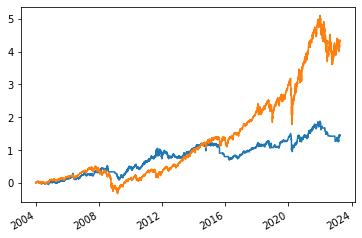

In [5]:
pt.cumulative_returns(strategy.strategy_returns.sum(1).loc['2004':]).plot()
pt.cumulative_returns(strategy.etf_close_returns['SPY'].loc['2004':]).plot()

<AxesSubplot:>

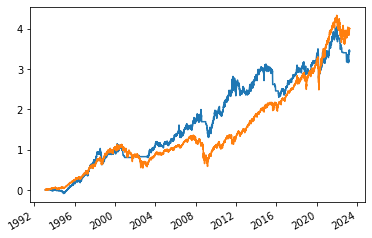

In [6]:
pt.cumulative_returns(pt.scale_vol(strategy.strategy_returns.sum(1))).plot()
pt.cumulative_returns(pt.scale_vol(strategy.etf_close_returns['SPY'])).plot()

In [7]:
pt.performance_summary(strategy.strategy_returns.sum(1))

,Performance Summary
Sharpe Ratio,0.544
Drift Adjusted Sharpe Ratio,8.916
CAGR,0.062
Vol,0.126
Sortino Ratio,0.672
Martin (Ulcer) Ratio,0.674
Omega Ratio,1.001
RR Ratio,1.117
Win Rate,0.547
Skew,-0.733


In [8]:
pt.performance_summary(pt.scale_vol(strategy.etf_close_returns['SPY']))

,Performance Summary
Sharpe Ratio,0.584
Drift Adjusted Sharpe Ratio,2.936
CAGR,0.055
Vol,0.100
Sortino Ratio,0.747
Martin (Ulcer) Ratio,0.746
Omega Ratio,0.983
RR Ratio,1.117
Win Rate,0.542
Skew,-0.056


In [ ]:
def high_low_index(returns, lookback_window=252)